https://towardsdatascience.com/populating-a-network-graph-with-named-entities-fb8e3d2a380f


https://pypi.org/project/newspaper3k/

這邊之前版本的

In [ ]:
!pip install -U spacy
!python -m spacy download en
!pip install networkx
!pip install fuzzywuzzy

     |████████████████████████████████| 12.8MB 288kB/s 
     |████████████████████████████████| 460kB 41.6MB/s 
     |████████████████████████████████| 9.1MB 35.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.1MB 27.5MB/s 
     |████████████████████████████████| 122kB 42.3MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-cp37-none-any.whl size=107098 sha256=290c53282a041cd82b75f20705149d67c860ef1a7011b5ea940b3de12cc33817
  Stored in directory: /root/.cache/pip/wheels/18/88/7c/f06dabd5e9cabe02d2269167bcacbbf9b47d0c0ff7d6ebcb78
Successfully built smart-open
  Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Found existing installation: smart-open 5.0.0
    Uninstalling smart-open-5.0.0:
      Successfully uninstalled smart-open-

In [ ]:
import pandas as pd
import numpy as np
import pickle
from operator import itemgetter
from fuzzywuzzy import process, fuzz
# for natural language processing
import spacy
import en_core_web_sm
# for visualizations
%matplotlib inline
from matplotlib.pyplot import figure
import networkx as nx
!pip install newspaper3k


     |████████████████████████████████| 215kB 4.0MB/s 
     |████████████████████████████████| 92kB 4.7MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 7.4MB 6.7MB/s 
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp37-none-any.whl size=7398406 sha256=9d826e437e03c03f7e580705f1b68ce157e9696851d960bdc6f5bc97d1773a0f
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp37-none-any.whl size=13538 sha256=500d3280eeccbf03a006fe651544b78251ef43e7f3ec9f72ca816ebb7a4ff5b9
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp37-none-any.whl size=3358 sha256=d369aadb8b4f7439863d20b4d8220394080bf22f5dd001b424bb9ca2ed04f0b8
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c75

In [ ]:
import requests
import json
import time
import newspaper
import pickle

# npr = newspaper.build('http://fox13now.com/2013/12/30/new-year-new-laws-obamacare-pot-guns-and-drones/')
npr = newspaper.build('https://www.npr.org/sections/national/')
# npr = newspaper.build('https://www.npr.org/sections/world/')

corpus = []
count = 0
for article in npr.articles:
    time.sleep(1)
    article.download()
    article.parse()
    text = article.text
    corpus.append(text)
    if count % 10 == 0 and count != 0:
        print('Obtained {} articles'.format(count))
    count += 1

corpus300 = corpus[:300]

with open("npr_coronavirus.txt", "wb") as fp:   # Pickling
    pickle.dump(corpus300, fp)

# with open("npr_coronavirus.txt", "rb") as fp:   # Unpickling
#     corpus = pickle.load(fp)

In [ ]:
with open('npr_coronavirus.txt', 'rb') as fp:   # Unpickling
    corpus = pickle.load(fp)

In [ ]:
nlp = en_core_web_sm.load()

In [ ]:
entities = []
for article in corpus[:50]:
    tokens = nlp(''.join(article))
    gpe_list = []
    for ent in tokens.ents:
        if ent.label_ == 'GPE':
            gpe_list.append(ent.text)
    entities.append(gpe_list)

In [ ]:
articles = []
for entity_list in entities:
    cleaned_entity_list = []
    for entity in entity_list:
        cleaned_entity_list.append(entity.lstrip('the ').replace("'s", "").replace("’s",""))
    articles.append(cleaned_entity_list)

In [ ]:
choices = set([item for sublist in articles for item in sublist])

cleaned_articles = []
for article in articles:
    article_entities = []
    for entity in set(article):
        article_entities.append(process.extractOne(entity, choices)[0])
    cleaned_articles.append(article_entities)

In [ ]:
articles = [article for article in articles if article != []]

In [ ]:
G = nx.Graph()

In [ ]:
for entities in articles:
    G.add_nodes_from(entities)

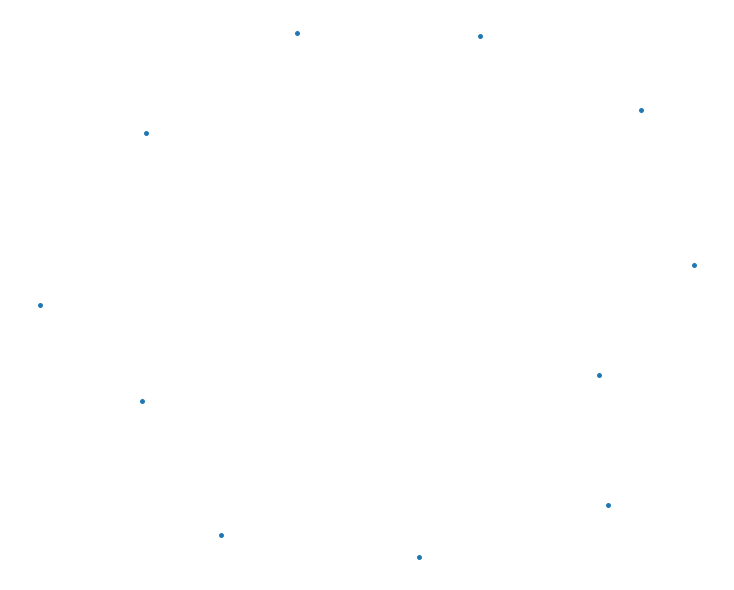

In [ ]:
figure(figsize=(10, 8))
nx.draw(G, node_size=15)

In [ ]:
for entities in articles:
    if len(entities) > 1:
        for i in range(len(entities)-1):
           G.add_edges_from([(str(entities[i]),str(entities[i+1]))])

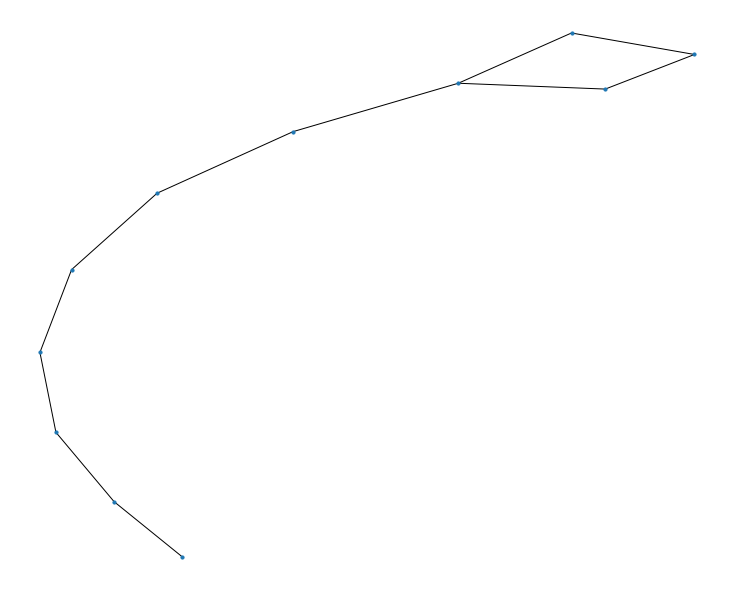

In [ ]:
figure(figsize=(10, 8))
nx.draw(G, node_size=10)

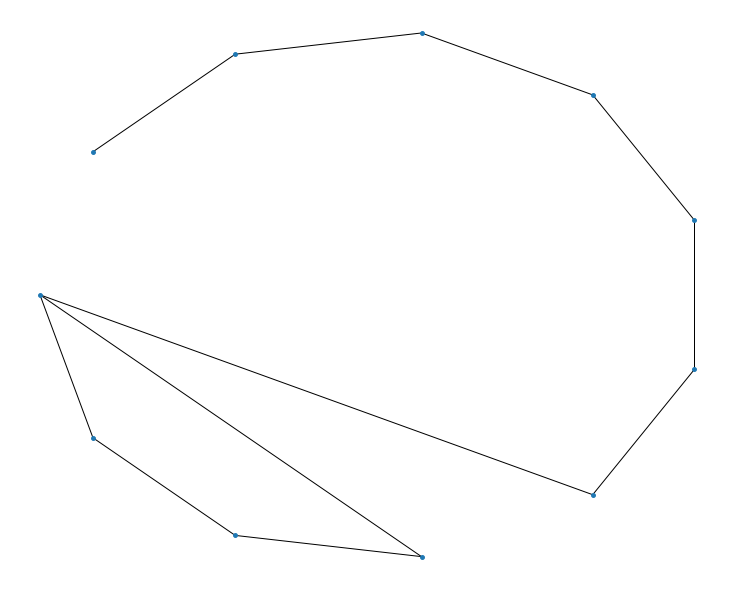

In [ ]:
figure(figsize=(10, 8))
nx.draw_shell(G, node_size=15)

In [ ]:
G.degree()

DegreeView({'Los Angeles': 3, 'America': 2, 'Jackson': 2, 'Mississippi': 2, 'New York City': 2, 'Chicago': 2, 'Richmond': 2, 'Virginia': 2, 'Oakland': 2, 'California': 2, 'Stockton': 1})

In [ ]:
max(dict(G.degree()).items(), key = lambda x : x[1])

('Los Angeles', 3)

In [ ]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

In [ ]:
print("Top 5 nodes by degree:")
for d in sorted_degree[:5]:
    print(d)

Top 5 nodes by degree:
('Los Angeles', 3)
('America', 2)
('Jackson', 2)
('Mississippi', 2)
('New York City', 2)


In [ ]:
nx.write_gexf(G, "npr_coronavirus_GPE_50.gexf")